Sure! Let's perform PCA on the MNIST dataset using Python and PyTorch, visualize the original and reduced images using Seaborn, and plot the explained variance to understand how much variability each principal component captures.

**Here's a step-by-step guide with the code:**


In [9]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA




## 1. Load the MNIST dataset using PyTorch

We'll use the TorchVision library to download and load the MNIST dataset.


In [20]:
# Define a transform to convert PIL images to tensors
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0), (1,)),
    ]
)

# Download and load the training data
mnist_train = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)



## 2. Prepare the data for PCA

Flatten the 28x28 images into 784-dimensional vectors and convert them into a NumPy array for PCA.


In [21]:
# Get the data and labels
data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=len(mnist_train))
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Flatten images to (num_samples, 784)
images = images.view(-1, 28 * 28)
images = images.numpy()


In [22]:
images.mean(), images.std()

(np.float32(0.13066062), np.float32(0.30810776))

## 3. Perform PCA on the dataset

Use Scikit-learn's PCA implementation.


In [23]:
# Initialize PCA
pca = PCA()

# Fit PCA on the data
pca.fit(images)

# Calculate the cumulative explained variance ratio
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)




## 4. Plot the explained variance

Create a scree plot to show the variance explained by each principal component.



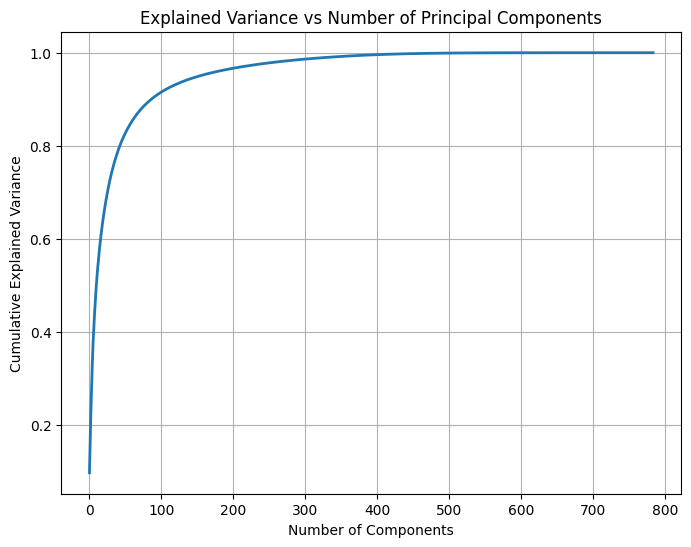

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(cum_explained_variance, linewidth=2)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of Principal Components")
plt.grid(True)
plt.show()




**Interpretation:**

This plot helps us decide how many principal components to keep. For instance, if we want to retain 95% of the variance, we'll choose the number of components where the cumulative explained variance reaches 0.95.

## 5. Reduce dimensionality

Let's choose a number of components that explain at least 95% of the variance.



In [25]:
# Find the number of components that explain at least 95% variance
n_components = 64  # np.argmax(cum_explained_variance >= 0.6) + 1
print(f"Number of components explaining 60% variance: {n_components}")

# Perform PCA with the selected number of components
pca = PCA(n_components=n_components)
images_reduced = pca.fit_transform(images)


Number of components explaining 60% variance: 64


## 6. Reconstruct images from the reduced data

Transform the reduced data back into the original space.


In [26]:
# Reconstruct images from reduced data
images_reconstructed = pca.inverse_transform(images_reduced)


## 7. Visualize original and reconstructed images

Use Seaborn (built on Matplotlib) to plot some examples.



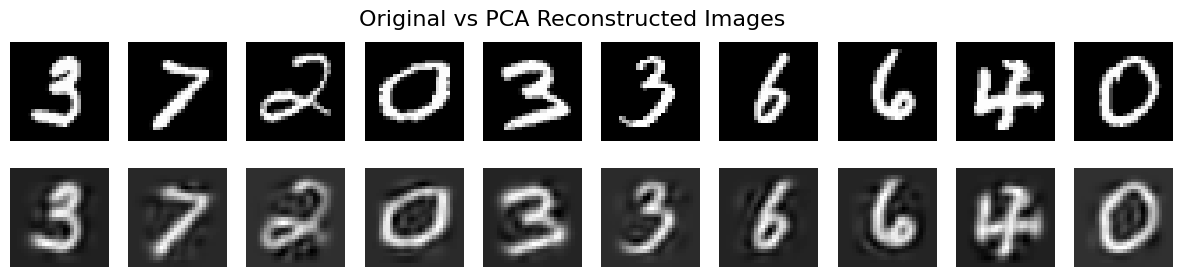

In [27]:
# Select some samples to visualize
num_samples = 10
indices = np.random.choice(len(images), num_samples, replace=False)

# Set up the figure
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 3))

for i, index in enumerate(indices):
    # Original image
    axes[0, i].imshow(images[index].reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Original", fontsize=12)

    # Reconstructed image
    axes[1, i].imshow(images_reconstructed[index].reshape(28, 28), cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("PCA Reconstruction", fontsize=12)

plt.suptitle("Original vs PCA Reconstructed Images", fontsize=16)
plt.show()




**Explanation:**

- The top row shows the original images.
- The bottom row shows the reconstructed images from the reduced PCA components.

You'll notice that while some details might be lost, the overall structure of the digits is preserved.

## 8. Visualize the variability explained (Detailed View)

Sometimes, it's helpful to see how much variance each component explains individually.



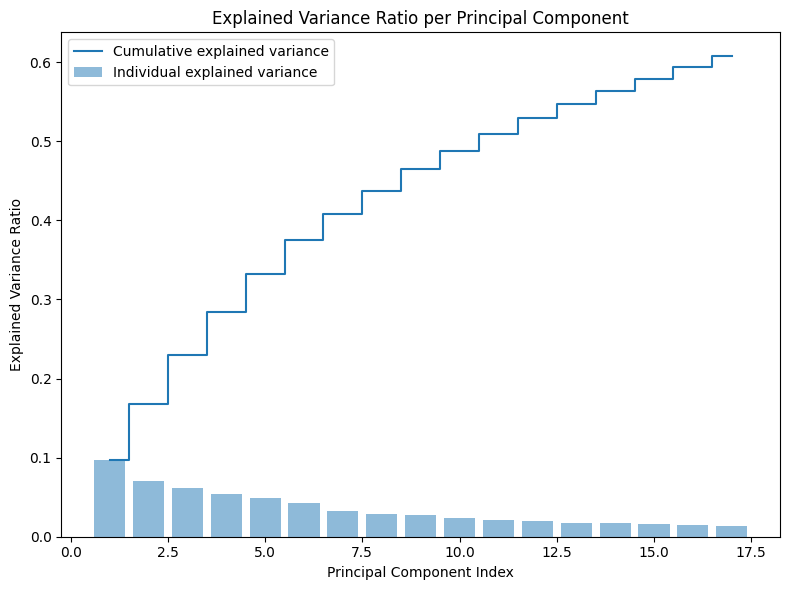

In [16]:
# Variance explained by each component
plt.figure(figsize=(8, 6))
plt.bar(
    range(1, n_components + 1),
    pca.explained_variance_ratio_,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(1, n_components + 1),
    cum_explained_variance[:n_components],
    where="mid",
    label="Cumulative explained variance",
)
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio per Principal Component")
plt.legend(loc="best")
plt.tight_layout()
plt.show()




**Interpretation:**

- The bar chart shows how much variance each principal component explains.
- The step plot shows the cumulative explained variance.


Sure! Let's build a linear autoencoder using PyTorch to reduce the dimensionality of the MNIST dataset. We'll see how using linear activation functions (i.e., no activation functions) in the autoencoder can produce similar results to PCA. We'll make the same kind of visualizations as before: plotting the explained variance and showing original vs reconstructed images.

## **2. Prepare the Data**

Since our autoencoder will expect flat vectors, we'll flatten the 28x28 images into 784-dimensional vectors. We'll also create a DataLoader for batching.



In [27]:
from torch.utils.data import DataLoader

# Updated transform to center data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x - 0.5)]
)

# Create DataLoader
batch_size = 256
mnist_train = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)



## **3. Define the Linear Autoencoder**

We'll define a linear autoencoder with no activation functions. This ensures the network is entirely linear, making it similar to PCA.



In [28]:
import torch.nn as nn


class LinearAutoencoder(nn.Module):
    def __init__(self, n_components):
        super(LinearAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Linear(784, n_components, bias=True)
        # Decoder
        self.decoder = nn.Linear(n_components, 784, bias=True)

    def forward(self, x):
        # Flatten the image
        x = x.view(-1, 28 * 28)
        # Encode
        x = self.encoder(x)
        # Decode
        x = self.decoder(x)
        return x



**Note**: We set `bias=False` to align more closely with PCA, which doesn't include biases.


## **4. Instantiate the Model, Define Loss Function and Optimizer**

We'll choose the same number of components that explained 95% variance in PCA. From the previous PCA analysis, suppose we found that 154 components explain 95% of the variance.



In [29]:
n_components = 17  # Number of components explaining 60% variance from PCA

model = LinearAutoencoder(n_components=n_components)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)




**Why Use SGD with Momentum?**

Using Stochastic Gradient Descent (SGD) with momentum can sometimes yield better convergence for linear networks.





## **5. Train the Autoencoder**

We'll train the autoencoder for a few epochs.



In [30]:
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(-1, 28 * 28))
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()

        running_loss += loss.item()
    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}")


Epoch [1/20], Loss: 0.254296
Epoch [2/20], Loss: 0.249472
Epoch [3/20], Loss: 0.245938
Epoch [4/20], Loss: 0.242656
Epoch [5/20], Loss: 0.239503
Epoch [6/20], Loss: 0.236419
Epoch [7/20], Loss: 0.233354
Epoch [8/20], Loss: 0.230290
Epoch [9/20], Loss: 0.227211
Epoch [10/20], Loss: 0.224098
Epoch [11/20], Loss: 0.220942
Epoch [12/20], Loss: 0.217732
Epoch [13/20], Loss: 0.214468
Epoch [14/20], Loss: 0.211134
Epoch [15/20], Loss: 0.207732
Epoch [16/20], Loss: 0.204253
Epoch [17/20], Loss: 0.200696
Epoch [18/20], Loss: 0.197061
Epoch [19/20], Loss: 0.193343
Epoch [20/20], Loss: 0.189546


## **6. Reconstruct Images**

We'll use the trained autoencoder to reconstruct images.



In [31]:
# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Pass images through the autoencoder
with torch.no_grad():
    outputs = model(images)

# Reshape outputs
outputs = outputs.view(-1, 1, 28, 28)

# Since the outputs are centered around zero, we need to shift them back
outputs = outputs + 0.5  # Shift back to [0,1] range
images = images + 0.5  # Shift images back to [0,1] for visualization



## **7. Visualize Original and Reconstructed Images**

We'll compare some original images with their reconstructed counterparts.


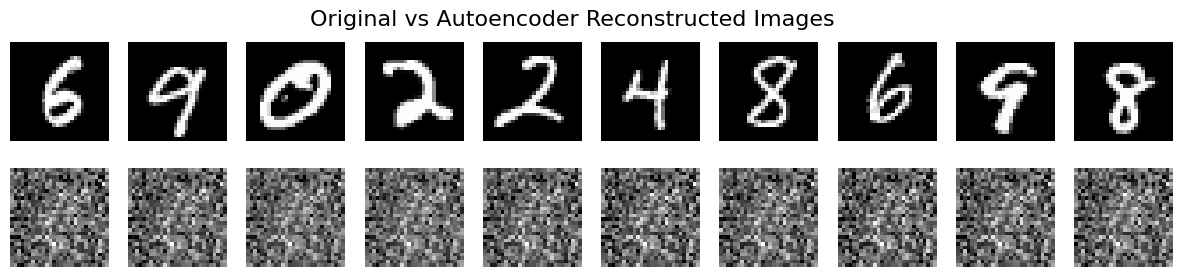

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Convert images and outputs to numpy arrays
images_np = images.numpy()
outputs_np = outputs.numpy()

# Clip values to [0,1] range to avoid any visualization issues
images_np = np.clip(images_np, 0, 1)
outputs_np = np.clip(outputs_np, 0, 1)

# Plot the original and reconstructed images
num_samples = 10
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 3))
for i in range(num_samples):
    # Original images
    axes[0, i].imshow(np.squeeze(images_np[i]), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Original", fontsize=12)
    # Reconstructed images
    axes[1, i].imshow(np.squeeze(outputs_np[i]), cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("Reconstructed", fontsize=12)
plt.suptitle("Original vs Autoencoder Reconstructed Images", fontsize=16)
plt.show()


In [ ]:


**Visualization Explanation**:

- **Top Row**: Original MNIST images.
- **Bottom Row**: Reconstructed images from the autoencoder.

---

## **8. Compute the Explained Variance**

To compute the explained variance, we'll:

- Pass the entire dataset through the encoder to obtain the latent representations.
- Compute the variance along each dimension of the latent space.
- Calculate the explained variance ratio.

**Compute the Encodings**:

```python
# Collect all encoded data
encoded_data = []

with torch.no_grad():
    for data in train_loader:
        img, _ = data
        img = img.view(-1, 28*28)
        encoded = model.encoder(img)
        encoded_data.append(encoded)

# Concatenate all encoded data
encoded_data = torch.cat(encoded_data, dim=0)
```

**Compute Variance Along Each Component**:

```python
# Convert to numpy
encoded_data_np = encoded_data.numpy()

# Compute variance of each component
encoded_variances = np.var(encoded_data_np, axis=0)
```

**Calculate Explained Variance Ratio**:

```python
# Total variance
total_encoded_variance = np.sum(encoded_variances)

# Explained variance ratio for each component
explained_variance_ratio = encoded_variances / total_encoded_variance

# Compute cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
```

---

## **9. Plot the Explained Variance**

We'll visualize the cumulative explained variance to see how variance is captured by the components.

```python
plt.figure(figsize=(8,6))
plt.plot(cumulative_explained_variance, linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components (Autoencoder)')
plt.grid(True)
plt.show()
```

---

## **10. Compare with PCA**

For comparison, let's overlay the cumulative explained variance from PCA.

**Assuming you have `cum_explained_variance` from the previous PCA**:

```python
# If you have 'cum_explained_variance' from PCA
plt.figure(figsize=(8,6))
plt.plot(cumulative_explained_variance, label='Autoencoder', linewidth=2)
plt.plot(cum_explained_variance[:n_components], label='PCA', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Comparison: Autoencoder vs PCA')
plt.legend()
plt.grid(True)
plt.show()
```

**Note**: Ensure that `cum_explained_variance` from PCA corresponds to the same number of components (`n_components`).

---


In [33]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Updated transform to center data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x - 0.5)]
)

# Load MNIST dataset with the updated transform
mnist_train = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)
train_loader = DataLoader(mnist_train, batch_size=256, shuffle=True)


# Define Linear Autoencoder with biases
class LinearAutoencoder(nn.Module):
    def __init__(self, n_components):
        super(LinearAutoencoder, self).__init__()
        self.encoder = nn.Linear(784, n_components)  # bias=True by default
        self.decoder = nn.Linear(n_components, 784)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


n_components = 154
model = LinearAutoencoder(n_components=n_components)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Increase number of epochs
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(-1, 28 * 28))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}")


Epoch [1/20], Loss: 0.217829
Epoch [2/20], Loss: 0.182688
Epoch [3/20], Loss: 0.148777
Epoch [4/20], Loss: 0.115993
Epoch [5/20], Loss: 0.092639
Epoch [6/20], Loss: 0.079713
Epoch [7/20], Loss: 0.073469
Epoch [8/20], Loss: 0.070535
Epoch [9/20], Loss: 0.069056
Epoch [10/20], Loss: 0.068225
Epoch [11/20], Loss: 0.067658
Epoch [12/20], Loss: 0.067202
Epoch [13/20], Loss: 0.066831
Epoch [14/20], Loss: 0.066476
Epoch [15/20], Loss: 0.066145
Epoch [16/20], Loss: 0.065841
Epoch [17/20], Loss: 0.065533
Epoch [18/20], Loss: 0.065243
Epoch [19/20], Loss: 0.064975
Epoch [20/20], Loss: 0.064696


AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [40]:
# Reconstruct images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images_flat = images.view(images.size(0), -1)
with torch.no_grad():
    outputs = model(images_flat)
# outputs = outputs.view(-1, 1, 28, 28)
outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data

# Shift outputs and images back to [0,1] range for visualization
outputs = outputs + 0.5
images = images + 0.5

# Convert to numpy and clip
images_np = images.numpy()
outputs_np = outputs.numpy()
images_np = np.clip(images_np, 0, 1)
outputs_np = np.clip(outputs_np, 0, 1)


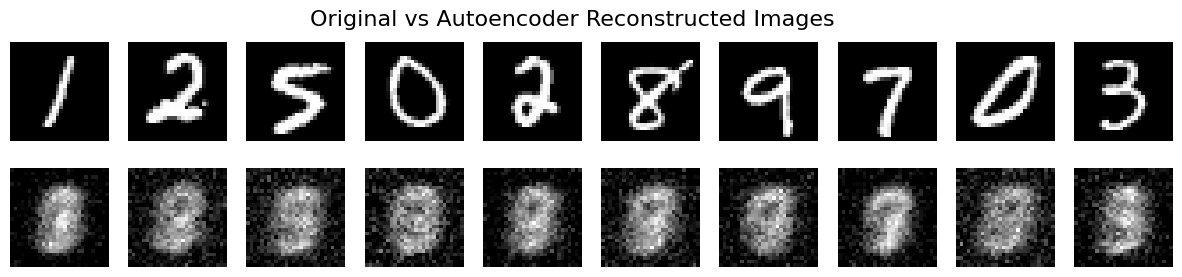

In [41]:
# Visualize
num_samples = 10
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[0, i].imshow(np.squeeze(images_np[i]), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Original", fontsize=12)
    axes[1, i].imshow(np.squeeze(outputs_np[i]), cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("Reconstructed", fontsize=12)
plt.suptitle("Original vs Autoencoder Reconstructed Images", fontsize=16)
plt.show()


In [36]:
# Compute explained variance
encoded_data = []
with torch.no_grad():
    for data in train_loader:
        img, _ = data
        img = img.view(-1, 28 * 28)
        encoded = model.encoder(img)
        encoded_data.append(encoded)
encoded_data = torch.cat(encoded_data, dim=0)
encoded_data_np = encoded_data.numpy()
encoded_variances = np.var(encoded_data_np, axis=0)
total_variance = np.sum(encoded_variances)
explained_variance_ratio = encoded_variances / total_variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)


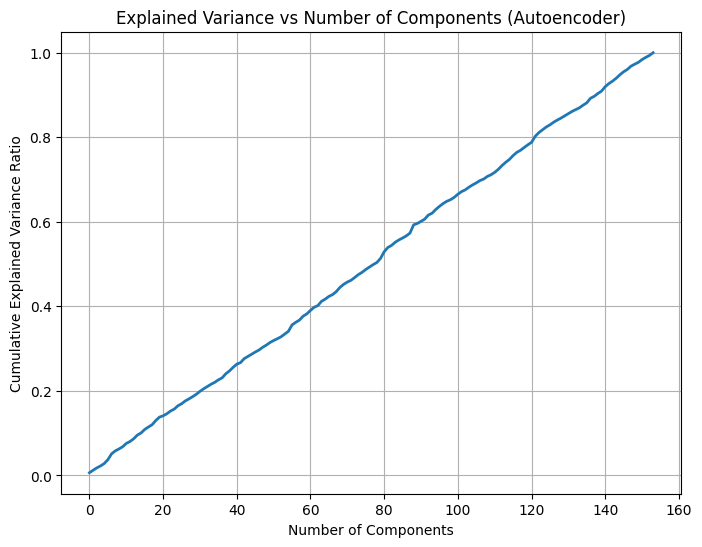

In [37]:
# Plot explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, linewidth=2)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance vs Number of Components (Autoencoder)")
plt.grid(True)
plt.show()

Epoch [1/20], Loss: 0.037722
Epoch [2/20], Loss: 0.007784
Epoch [3/20], Loss: 0.004688
Epoch [4/20], Loss: 0.003768
Epoch [5/20], Loss: 0.003344
Epoch [6/20], Loss: 0.003049
Epoch [7/20], Loss: 0.002911
Epoch [8/20], Loss: 0.002833
Epoch [9/20], Loss: 0.002783
Epoch [10/20], Loss: 0.002750
Epoch [11/20], Loss: 0.002728
Epoch [12/20], Loss: 0.002711
Epoch [13/20], Loss: 0.002698
Epoch [14/20], Loss: 0.002688
Epoch [15/20], Loss: 0.002680
Epoch [16/20], Loss: 0.002675
Epoch [17/20], Loss: 0.002671
Epoch [18/20], Loss: 0.002668
Epoch [19/20], Loss: 0.002666
Epoch [20/20], Loss: 0.002665


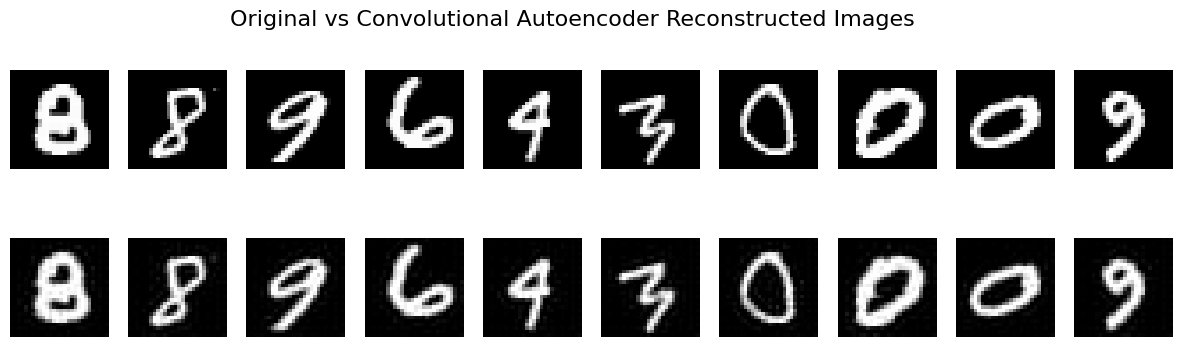

In [42]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Transform to center the data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x - 0.5)]
)

# Load MNIST dataset
mnist_train = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)
train_loader = DataLoader(mnist_train, batch_size=256, shuffle=True)


# Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                1, 16, kernel_size=3, stride=2, padding=1, bias=False
            ),  # [batch, 16, 14, 14]
            # No activation function
            nn.Conv2d(
                16, 8, kernel_size=3, stride=2, padding=1, bias=False
            ),  # [batch, 8, 7, 7]
            # No activation function
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                8, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False
            ),  # [batch, 16, 14, 14]
            # No activation function
            nn.ConvTranspose2d(
                16, 1, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False
            ),  # [batch, 1, 28, 28]
            # No activation function
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Instantiate the model, define loss function and optimizer
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}")

# Reconstruct images
dataiter = iter(train_loader)
images, labels = next(dataiter)
with torch.no_grad():
    outputs = model(images)

# Shift outputs back to [0,1] range
images = images + 0.5
outputs = outputs + 0.5

# Clip values to [0,1] range
images = torch.clamp(images, 0, 1)
outputs = torch.clamp(outputs, 0, 1)

# Convert to numpy for visualization
images_np = images.numpy()
outputs_np = outputs.numpy()

# Visualize original and reconstructed images
num_samples = 10
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 4))
for i in range(num_samples):
    axes[0, i].imshow(np.squeeze(images_np[i]), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Original", fontsize=12)
    axes[1, i].imshow(np.squeeze(outputs_np[i]), cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("Reconstructed", fontsize=12)
plt.suptitle("Original vs Convolutional Autoencoder Reconstructed Images", fontsize=16)
plt.show()

Epoch [1/20], Loss: 0.229328
Epoch [2/20], Loss: 0.219945
Epoch [3/20], Loss: 0.205730
Epoch [4/20], Loss: 0.174767
Epoch [5/20], Loss: 0.116571
Epoch [6/20], Loss: 0.079406
Epoch [7/20], Loss: 0.069381
Epoch [8/20], Loss: 0.067171
Epoch [9/20], Loss: 0.066673
Epoch [10/20], Loss: 0.066554
Epoch [11/20], Loss: 0.066509
Epoch [12/20], Loss: 0.066478
Epoch [13/20], Loss: 0.066460
Epoch [14/20], Loss: 0.066430
Epoch [15/20], Loss: 0.066412
Epoch [16/20], Loss: 0.066396
Epoch [17/20], Loss: 0.066365
Epoch [18/20], Loss: 0.066351
Epoch [19/20], Loss: 0.066335
Epoch [20/20], Loss: 0.066315


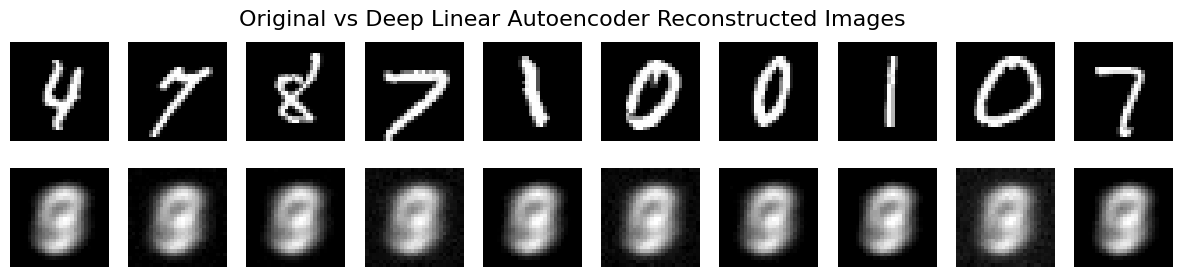

In [43]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Transform to center the data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x - 0.5)]
)

# Load MNIST dataset
mnist_train = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)
train_loader = DataLoader(mnist_train, batch_size=256, shuffle=True)


# Define Deep Linear Autoencoder
class DeepLinearAutoencoder(nn.Module):
    def __init__(self, n_components):
        super(DeepLinearAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            # No activation function
            nn.Linear(512, 256),
            # No activation function
            nn.Linear(256, n_components),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(n_components, 256),
            # No activation function
            nn.Linear(256, 512),
            # No activation function
            nn.Linear(512, 784),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


n_components = 154
model = DeepLinearAutoencoder(n_components=n_components)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Train the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(-1, 28 * 28))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.6f}")

# Reconstruct images
dataiter = iter(train_loader)
images, labels = next(dataiter)
with torch.no_grad():
    outputs = model(images)
outputs = outputs.view(-1, 1, 28, 28)

# Shift outputs and images back to [0,1] range for visualization
outputs = outputs + 0.5
images = images + 0.5

# Convert to numpy and clip
images_np = images.numpy()
outputs_np = outputs.numpy()
images_np = np.clip(images_np, 0, 1)
outputs_np = np.clip(outputs_np, 0, 1)

# Visualize
num_samples = 10
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[0, i].imshow(np.squeeze(images_np[i]), cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_ylabel("Original", fontsize=12)
    axes[1, i].imshow(np.squeeze(outputs_np[i]), cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("Reconstructed", fontsize=12)
plt.suptitle("Original vs Deep Linear Autoencoder Reconstructed Images", fontsize=16)
plt.show()